# 语言模型与数据集

In [3]:
%matplotlib inline
import random
import torch
import matplotlib.pyplot as plt
import random
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')
from funcs import read_time_machine, tokenize, Vocab

## 自然语言统计
在真实数据上如果进行自然语言统计。 根据时光机器数据集构建词表， 并打印前个最常用的（频率最高的）单词。

In [45]:
tokens = tokenize(read_time_machine())
corpus = [token for line in tokens for token in line]
vocab = Vocab(corpus)
vocab._token_freqs[:10]

[('the', 2285),
 ('i', 1268),
 ('and', 1245),
 ('of', 1163),
 ('a', 819),
 ('to', 684),
 ('was', 552),
 ('in', 545),
 ('that', 443),
 ('my', 441)]

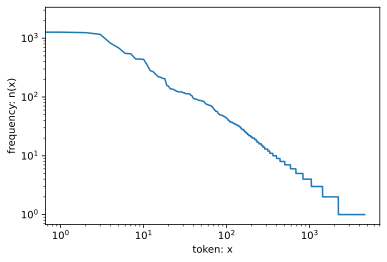

In [46]:
axes = plt.gca()
axes.set_xscale("log")
axes.set_yscale("log")
plt.xlabel("token: x")
plt.ylabel("frequency: n(x)")
plt.plot([freq for token, freq in vocab._token_freqs[::]])

词频以一种明确的方式迅速衰减。 将前几个单词作为例外消除后，剩余的所有单词大致遵循双对数坐标图上的一条直线。

In [47]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]  # 将所有单词错开组合, 查看两两单词的组合频率
bigram_vocab = Vocab(bigram_tokens)
len(bigram_vocab), bigram_vocab._token_freqs[:10]

(20309,
 [(('of', 'the'), 309),
  (('in', 'the'), 173),
  (('i', 'had'), 130),
  (('i', 'was'), 112),
  (('and', 'the'), 109),
  (('the', 'time'), 106),
  (('it', 'was'), 99),
  (('to', 'the'), 85),
  (('as', 'i'), 78),
  (('of', 'a'), 73)])

In [48]:
trigram_tokens = [pair for pair in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = Vocab(trigram_tokens)
len(trigram_vocab), trigram_vocab._token_freqs[:10]

(29976,
 [(('the', 'time', 'traveller'), 63),
  (('the', 'time', 'machine'), 30),
  (('the', 'medical', 'man'), 24),
  (('it', 'seemed', 'to'), 16),
  (('it', 'was', 'a'), 15),
  (('here', 'and', 'there'), 15),
  (('seemed', 'to', 'me'), 14),
  (('i', 'did', 'not'), 14),
  (('i', 'saw', 'the'), 13),
  (('the', 'white', 'sphinx'), 12)])

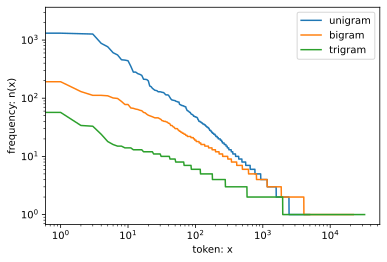

In [44]:
axes = plt.gca()
axes.set_xscale("log")
axes.set_yscale("log")
plt.xlabel("token: x")
plt.ylabel("frequency: n(x)")
plt.plot([freq for token, freq in vocab._token_freqs[::]], label="unigram")
plt.plot([freq for token, freq in bigram_vocab._token_freqs[::]], label="bigram")
plt.plot([freq for token, freq in trigram_vocab._token_freqs[::]], label="trigram")
plt.legend()

从图中可见，除了一元语法词，单词序列也遵循齐普夫定律: $ log(n_{i}) = -\alpha log(i) + c $

## 读取长序列的数据
由于序列数据本质上是连续的，因此我们在处理数据时需要解决这个问题。  当序列变得太长而不能被模型一次性全部处理时， 拆分这样的序列方便模型读取。
- 实现随机采样（random sampling）和 顺序分区（sequential partitioning）策略
- 下面的代码每次从数据中随机生成一个小批量。 参数batch_size指定每个小批量中子序列样本的数目， 参数num_steps是每个子序列中预定义的时间步数。

In [15]:
def seq_data_iter_random(corpus:list, batch_size:int, num_steps:int):
    """词组序列, 批量, 分区长度, 生成 序列 及 该序列的预测结果(后面紧跟的一个词元)"""
    # 舍去前端来产生偏移
    corpus = corpus[random.randint(0, num_steps-1):]
    # 索引数目
    num_samples = len(corpus) // (num_steps + 1)
    # 生成起始词的索引值
    init_indices = [i * (num_steps + 1) for i in range(num_samples)]
    # 打乱索引
    random.shuffle(init_indices)
    out_x, out_y = [], []
    for k, i in enumerate(init_indices):
        out_x.append(corpus[i:i+num_steps])
        out_y.append(corpus[i+num_steps])
        if (k+1) % batch_size == 0:
            yield out_x, out_y
            out_x, out_y = [], []
    if out_x:
        yield out_x, out_y

In [21]:
test = [i for i in range(100)]
for x, y in seq_data_iter_random(test, 2, 5):
    print(f"X:{x}\tY:{y}")

X:[[76, 77, 78, 79, 80], [10, 11, 12, 13, 14]]	Y:[81, 15]
X:[[64, 65, 66, 67, 68], [70, 71, 72, 73, 74]]	Y:[69, 75]
X:[[28, 29, 30, 31, 32], [52, 53, 54, 55, 56]]	Y:[33, 57]
X:[[16, 17, 18, 19, 20], [94, 95, 96, 97, 98]]	Y:[21, 99]
X:[[82, 83, 84, 85, 86], [58, 59, 60, 61, 62]]	Y:[87, 63]
X:[[22, 23, 24, 25, 26], [40, 41, 42, 43, 44]]	Y:[27, 45]
X:[[88, 89, 90, 91, 92], [46, 47, 48, 49, 50]]	Y:[93, 51]
X:[[34, 35, 36, 37, 38], [4, 5, 6, 7, 8]]	Y:[39, 9]
